## **Sentiment analysis using Word to vector embeddings and LSTM.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We download the pre-trained word embeddings.

In [ ]:
!wget --no-check-certificate \
    "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" \
    -O /tmp/GoogleNews-vectors-negative300.bin.gz

--2021-05-20 11:57:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.138.40
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.138.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/tmp/GoogleNews-vectors-negative300.bin.gz’

/tmp/GoogleNews-vec 100%[===================>]   1.53G  42.2MB/s    in 38s     

2021-05-20 11:57:47 (40.9 MB/s) - ‘/tmp/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



Next we extract them into a temporary folder:

In [ ]:
!gunzip /tmp/GoogleNews-vectors-negative300.bin.gz 

In [ ]:
!ls /tmp 

dap_multiplexer.66520c683856.root.log.INFO.20210520-115244.52
dap_multiplexer.INFO
debugger_1ade26io5q
drivefs_ipc.0
drivefs_ipc.0_shell
GoogleNews-vectors-negative300.bin
initgoogle_syslog_dir.0
tmp67j6_z43


In [ ]:
!pip install gensim

In [ ]:
from gensim.models import KeyedVectors


Loading the Dataset.

In [ ]:
df = pd.read_json('/content/Amazon_Instant_Video_5.json', lines = True)
df.head()

reviewerID        asin  ... unixReviewTime   reviewTime
0  A11N155CW1UV02  B000H00VBQ  ...     1399075200   05 3, 2014
1  A3BC8O2KCL29V2  B000H00VBQ  ...     1346630400   09 3, 2012
2   A60D5HQFOTSOM  B000H00VBQ  ...     1381881600  10 16, 2013
3  A1RJPIGRSNX4PW  B000H00VBQ  ...     1383091200  10 30, 2013
4  A16XRPF40679KG  B000H00VBQ  ...     1234310400  02 11, 2009

[5 rows x 9 columns]

In [ ]:
len(df)

37126

In [ ]:
df = df.sample(n=10000)

In [ ]:
len(df)

10000

In [ ]:
df["textlength"] = df["reviewText"].apply(len)

In [ ]:
df.describe()

overall  unixReviewTime    textlength
count  10000.000000    1.000000e+04  10000.000000
mean       4.213900    1.376372e+09    523.686400
std        1.109896    3.127193e+07    838.978927
min        1.000000    1.157155e+09      4.000000
25%        4.000000    1.367626e+09    145.000000
50%        5.000000    1.384733e+09    234.000000
75%        5.000000    1.394064e+09    491.000000
max        5.000000    1.406074e+09  13279.000000

In [ ]:
df.head()

reviewerID        asin  ...   reviewTime textlength
17249  A28W9C3T3H2T53  B009F7QE0E  ...   12 5, 2012        311
6452   A3USPMZAS3L3AZ  B003Y5QRJ6  ...   08 4, 2013        377
194    A2PEU4WKCDJ107  B000I9TWV6  ...  09 29, 2013        120
30475  A34OJWGNJAOPUZ  B00F6PKYX2  ...  12 17, 2013        705
26097  A2FAFPND21JMIN  B00D6BR75Q  ...   11 9, 2013        221

[5 rows x 10 columns]

In [ ]:
df.tail()

reviewerID        asin  ...   reviewTime textlength
19173   AUC70HIL65YAR  B009RURGHO  ...  04 27, 2014        295
18063  A2ZURBQU5IH7VR  B009IJJ5B4  ...  05 19, 2013        246
1324   A27G2N2F7EN3SD  B000VU4GW2  ...  12 20, 2013        462
22526  A3UXWUR06H122K  B00BR34W3U  ...  09 24, 2013        193
23525  A1CIQKOEKFOX3M  B00CBKUWKA  ...  04 20, 2013        351

[5 rows x 10 columns]

In [ ]:
df['reviewText']

17249    Here is another show that breaks from the norm...
6452     The plot was great and Bruce Payne was outstan...
194      Age appropriate cartoon packed with learning f...
30475    If you're a fan of the Avatar series in genera...
26097    My grandchildren love Dora and I like it as we...
                               ...                        
19173    Well done historical story. Shows how the tita...
18063    Miller establishes his character's quirkiness ...
1324     My wife and I watched all of Seasons 1 and 2, ...
22526    We bought this for our granddaughters, and the...
23525    Not as good as some of the other ones like par...
Name: reviewText, Length: 10000, dtype: object

In [ ]:
df = df[['reviewText', 'overall']]
df.head()

reviewText  overall
17249  Here is another show that breaks from the norm...        5
6452   The plot was great and Bruce Payne was outstan...        4
194    Age appropriate cartoon packed with learning f...        4
30475  If you're a fan of the Avatar series in genera...        5
26097  My grandchildren love Dora and I like it as we...        5

In [ ]:
df['overall'] = [1 if overall > 2 else 0 
                            for overall in df['overall'].values]
df.head()

reviewText  overall
17249  Here is another show that breaks from the norm...        1
6452   The plot was great and Bruce Payne was outstan...        1
194    Age appropriate cartoon packed with learning f...        1
30475  If you're a fan of the Avatar series in genera...        1
26097  My grandchildren love Dora and I like it as we...        1

In [ ]:
df.shape

(10000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 17249 to 23525
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  10000 non-null  object
 1   overall     10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.4+ KB


In [ ]:
df['overall'].value_counts()

1    9058
0     942
Name: overall, dtype: int64

Spliting the data into train and test sets:

In [ ]:
X = df['reviewText']
y = df['overall']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

**Tokenizing the words.**

In [ ]:
vocab_size = 5000
embedding_dim = 16
max_len = 100
trunction_type='post'
padding_type='post'
oov_token = "<OOV>"

In [ ]:
tokenize = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenize.fit_on_texts(X_train_sentences)

The word index show us how words are mapped into numbers:

In [ ]:
word_index = tokenize.word_index

`texts_to_sequences` convert the words into sequences so that a complete sequence of numbers can represent every sentence. 

In [ ]:
X_train = tokenize.texts_to_sequences(X_train_sentences)
X_test = tokenize.texts_to_sequences(X_test_sentences)

In [ ]:
X_train

[[10,
  30,
  35,
  546,
  14,
  9,
  56,
  122,
  375,
  50,
  1,
  2625,
  3767,
  7,
  4,
  39,
  666,
  8,
  248,
  60,
  18,
  1028,
  3,
  77,
  2831,
  10,
  299,
  62,
  220,
  2,
  436,
  6,
  2,
  1395,
  1148,
  484,
  99,
  4471,
  13,
  45,
  2535,
  25,
  67,
  652,
  1038,
  342,
  1,
  2,
  16,
  263,
  4,
  3426,
  1,
  3768,
  2117,
  85,
  19,
  119,
  2,
  315],
 [8,
  102,
  10,
  7,
  2,
  68,
  138,
  341,
  455,
  712,
  5,
  865,
  48,
  424,
  91,
  642,
  13,
  52,
  1441,
  90,
  446,
  437,
  1,
  865,
  899,
  21,
  10,
  766,
  275,
  44,
  28,
  264,
  238,
  4,
  109,
  607,
  1,
  6,
  134,
  2832,
  12,
  1110,
  129,
  222,
  223,
  37,
  72,
  908,
  135,
  2717,
  53,
  6,
  2,
  1048,
  14,
  34,
  324,
  63,
  1442,
  208,
  11,
  2,
  1443,
  12,
  123,
  307,
  9,
  116,
  66,
  57,
  865,
  3,
  2536,
  13,
  129,
  27,
  2,
  33,
  481,
  425,
  10,
  199,
  23,
  154,
  31,
  395,
  286],
 [2,
  4472,
  151,
  219,
  1,
  1732,
  3979,
  5,


In [ ]:
X_train[9:11]

[[48,
  4,
  39,
  16,
  1602,
  2717,
  7,
  937,
  2,
  569,
  360,
  21,
  18,
  2,
  692,
  6,
  135,
  969,
  10,
  7,
  4,
  2013,
  8,
  339,
  236,
  30,
  817,
  2,
  902,
  7,
  1,
  8,
  79,
  22,
  1029,
  236,
  263,
  257,
  447,
  1500,
  78],
 [45,
  180,
  2839,
  169,
  535,
  10,
  16,
  8,
  28,
  12,
  9,
  7,
  22,
  83,
  229,
  14,
  1113,
  17,
  62,
  45,
  398,
  72,
  422,
  66,
  29,
  80,
  52,
  1180,
  9,
  7,
  332]]

Using `pad_sequences`function to make it uniform.

In [ ]:
X_train_pad = pad_sequences(X_train,maxlen=max_len, padding=padding_type, 
                            truncating=trunction_type)

X_test_pad = pad_sequences(X_test,maxlen=max_len, padding=padding_type, 
                           truncating=trunction_type)

### **Wordtovector Embedding**

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [69]:
import gensim
from nltk.tokenize import word_tokenize
sentences =  [word_tokenize(review) for review in X.to_list()]
model_word2vec = gensim.models.Word2Vec(sentences=sentences, size=1, window=5, workers=4, min_count=1)
words = list(model_word2vec.wv.vocab)
filename = 'amazon_product_reviews_embedding_word2vec.txt'
model_word2vec.wv.save_word2vec_format(filename, binary=False)
# creating dictionary of words containing corresponding word embeddings

In [70]:
embeddings_index = {}
f = open('amazon_product_reviews_embedding_word2vec.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 47375 word vectors.


In [ ]:
embedding_matrix = np.zeros((num_words, max_len))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Finally we create the embedding layer:


In [ ]:
embedding_layer = Embedding(num_words,
                            max_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

### **Build the model**
We create a model using embedding layer and Bidirectional LSTM layers. Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper and it  takes a recurrent layer as an argument.

In [ ]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)), 
    Bidirectional(LSTM(embedding_dim)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3011300   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 32)           14976     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 3,032,753
Trainable params: 21,453
Non-trainable params: 3,011,300
_________________________________________________________________


Train the model for 5 epochs.

In [ ]:
history = model.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/5
250/250 [==============================] - 28s 88ms/step - loss: 0.4356 - accuracy: 0.8662 - val_loss: 0.3328 - val_accuracy: 0.8940
Epoch 2/5
250/250 [==============================] - 20s 79ms/step - loss: 0.2912 - accuracy: 0.9135 - val_loss: 0.3335 - val_accuracy: 0.8940
Epoch 3/5
250/250 [==============================] - 20s 80ms/step - loss: 0.3063 - accuracy: 0.9071 - val_loss: 0.3328 - val_accuracy: 0.8940
Epoch 4/5
250/250 [==============================] - 20s 80ms/step - loss: 0.2976 - accuracy: 0.9104 - val_loss: 0.3319 - val_accuracy: 0.8940
Epoch 5/5
250/250 [==============================] - 20s 80ms/step - loss: 0.2971 - accuracy: 0.9109 - val_loss: 0.3304 - val_accuracy: 0.8940


Predictions on a test set:

In [ ]:
loss, accuracy = model.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

63/63 [==============================] - 2s 26ms/step - loss: 0.3304 - accuracy: 0.8940
Test accuracy : 0.8939999938011169


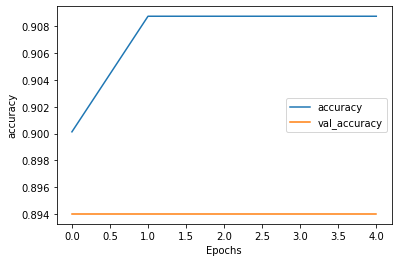

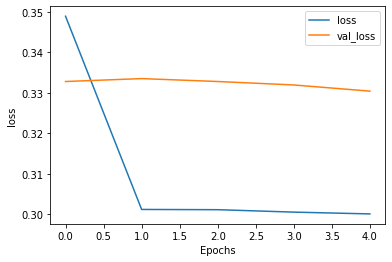

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [67]:
model.save("word_to_vector_model")

INFO:tensorflow:Assets written to: word_to_vector_model/assets


INFO:tensorflow:Assets written to: word_to_vector_model/assets


Adding the dropout layer for decrease overfitting and  we increase number of epochs to 10.

In [ ]:
model2 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True)), 
    Bidirectional(LSTM(32)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model2.compile(loss='binary_crossentropy', 
               optimizer=optimizer,
               metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3011300   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,138,053
Trainable params: 126,753
Non-trainable params: 3,011,300
______________________________________

In [ ]:
callbacks = EarlyStopping(monitor = 'val_accuracy', 
                          mode = 'max', 
                          patience = 10,
                          verbose = 1)

In [ ]:
history2 = model2.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
250/250 [==============================] - 48s 165ms/step - loss: 0.5172 - accuracy: 0.7567 - val_loss: 0.3344 - val_accuracy: 0.8940
Epoch 2/10
250/250 [==============================] - 39s 155ms/step - loss: 0.3591 - accuracy: 0.9110 - val_loss: 0.3330 - val_accuracy: 0.8940
Epoch 3/10
250/250 [==============================] - 39s 157ms/step - loss: 0.3707 - accuracy: 0.9067 - val_loss: 0.3330 - val_accuracy: 0.8940
Epoch 4/10
250/250 [==============================] - 39s 157ms/step - loss: 0.3607 - accuracy: 0.9085 - val_loss: 0.3315 - val_accuracy: 0.8940
Epoch 5/10
250/250 [==============================] - 40s 161ms/step - loss: 0.3536 - accuracy: 0.9095 - val_loss: 0.3312 - val_accuracy: 0.8940
Epoch 6/10
250/250 [==============================] - 42s 169ms/step - loss: 0.3469 - accuracy: 0.9134 - val_loss: 0.3303 - val_accuracy: 0.8940
Epoch 7/10
250/250 [==============================] - 39s 158ms/step - loss: 0.3373 - accuracy: 0.9149 - val_loss: 0.3295 - val_ac

Predictions:

In [ ]:
loss, accuracy = model2.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

63/63 [==============================] - 3s 47ms/step - loss: 0.3286 - accuracy: 0.8940
Test accuracy : 0.8939999938011169


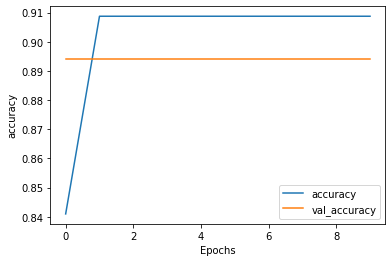

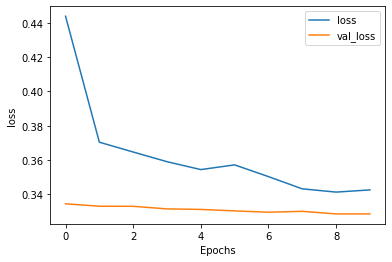

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")